In [632]:
from business_models import hahn, greenplum

import h3

from shapely.geometry import shape,Point,Polygon

import geopandas as gpd

import pandas as pd

import numpy as np

from shapely import wkt


# import geo_functions as gf

import os

import geo_functions as gf

from shapely import wkt

from datetime import datetime


import zone_prediction_functions as zpf

from importlib import reload
from dateutil.relativedelta import relativedelta
from matplotlib import pyplot as plt

In [612]:
reload(zpf)

<module 'zone_prediction_functions' from '/home/intra26/zone_prediction_functions.py'>

In [633]:
def receive_intersected_zones(gdf_zones,delivery_type='foot'):
    
    list_zones= gdf_zones.zone_id.unique().tolist()
   
    gdf_inter_current_new_zones = zpf.receive_intersected_zones( list_zones, delivery_type=delivery_type)
#     print(gdf_inter_current_new_zones.head())
    
    gdf_inter_current_new_zones['zone_id'] = gdf_inter_current_new_zones['current_zone']+'_'+gdf_inter_current_new_zones['delivery_type']
    
   
    gdf_inter_current_new_zones['geometry'] = gdf_inter_current_new_zones['current_zone_geometry']

    gdf_inter_current_new_zones['geometry_wkb']=None

    gdf_inter_current_new_zones['geometry'] = gdf_inter_current_new_zones.geometry.apply(lambda x: x.buffer(0.001).buffer(-0.001) if x.geom_type=='MultiPolygon'  else x)

    gdf_inter_current_new_zones['upload_dt']=datetime.today()
    
    gdf_inter_current_new_zones['inter_area']=gdf_inter_current_new_zones['inter_area'].apply(lambda x: wkt.loads(x))

    gdf_inter_current_new_zones['diff_geometry'] = gpd.GeoSeries(gdf_inter_current_new_zones['current_zone_geometry']).difference(gpd.GeoSeries(gdf_inter_current_new_zones['inter_area'],crs='epsg:4326'))
    
    return gdf_inter_current_new_zones
 

In [634]:
gdf_zones, case_name=zpf.receive_gdf_zones()

Если кейс новый - 1, если кейс был загружен ранее - 00
название кейсаmovement_spb
movement_spb


ERROR:Handler :ERROR in job  launched by /usr/lib/python3.7/runpy.py. <class 'sqlalchemy.exc.ProgrammingError'>: 
 Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sqlalchemy/engine/base.py", line 1809, in _execute_context
    cursor, statement, parameters, context
  File "/usr/local/lib/python3.7/dist-packages/sqlalchemy/engine/default.py", line 732, in do_execute
    cursor.execute(statement, parameters)
psycopg2.errors.SyntaxError: syntax error at or near ")"
LINE 1: ...t * from snb_geo_lavka.iat_zones2predict where zone_id in ()
                                                                      ^


The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/business_models/databases/database.py", line 67, in wrapper
    result = func(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/business_models/databases/database_sql.py", line 261, in __c

case contains 0 zones


ProgrammingError: (psycopg2.errors.SyntaxError) syntax error at or near ")"
LINE 1: ...t * from snb_geo_lavka.iat_zones2predict where zone_id in ()
                                                                      ^

[SQL: select * from snb_geo_lavka.iat_zones2predict where zone_id in ()]
(Background on this error at: https://sqlalche.me/e/14/f405)

In [635]:
df = greenplum("select id, st_astext(geometry) from snb_geo_lavka.spb_zones_suggest where type='movement'")

df.columns=['zone_id','geometry']

df['zone_id']=df['zone_id']+'_movement_spb'

df['upload_dt']=datetime.today()


df['geometry_wkb']=None

In [675]:
df = greenplum("select id, st_astext(geometry) from snb_geo_lavka.spb_store_suggest where type='movement'")

ERROR:Handler :ERROR in job  launched by /usr/lib/python3.7/runpy.py. <class 'sqlalchemy.exc.ProgrammingError'>: 
 Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sqlalchemy/engine/base.py", line 1809, in _execute_context
    cursor, statement, parameters, context
  File "/usr/local/lib/python3.7/dist-packages/sqlalchemy/engine/default.py", line 732, in do_execute
    cursor.execute(statement, parameters)
psycopg2.errors.UndefinedTable: relation "snb_geo_lavka.spb_store_suggest" does not exist
LINE 1: select id, st_astext(geometry) from snb_geo_lavka.spb_store_...
                                            ^


The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/business_models/databases/database.py", line 67, in wrapper
    result = func(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/business_models/databases/database_sql.py", line 261,

ProgrammingError: (psycopg2.errors.UndefinedTable) relation "snb_geo_lavka.spb_store_suggest" does not exist
LINE 1: select id, st_astext(geometry) from snb_geo_lavka.spb_store_...
                                            ^

[SQL: select id, st_astext(geometry) from snb_geo_lavka.spb_store_suggest where type='movement']
(Background on this error at: https://sqlalche.me/e/14/f405)

In [636]:
gdf_zones = df.copy()

In [591]:
# gdf_zones=gdf_zones.iloc[:2]

<AxesSubplot:>

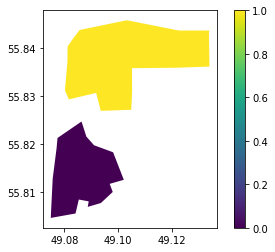

In [562]:
gdf_zones.reset_index().plot(column='index', legend=True)

In [621]:
new_store_zones = gdf_zones.zone_id.unique() # это верно только если гружу  новые зоны без соседей

In [699]:
new_store_zones

['21_movement_spb',
 '17_movement_spb',
 '18_movement_spb',
 '19_movement_spb',
 '23_movement_spb',
 '20_movement_spb',
 '22_movement_spb']

In [595]:
zpf.save2db(gdf_zones)

appended
zones ['zone_gosp_0', ''] are successfuly uploaded


In [638]:
case_name='movement_spb'

In [631]:
reload(zpf)

<module 'zone_prediction_functions' from '/home/intra26/zone_prediction_functions.py'>

Здесь должна быть развилка на 2 типа кейсов: 
    1. Дается одна зона на каждый сценарий и остальные уменьшаются на пересечение
    2. Дается несколько новых зон с геометрией и остальные уменьшаются на сумму пересечений или вообще не берутся в расчет

In [639]:
k=0
while k==0:
    print('1 - текущие и новые, где 2 - только текущие')
    flag_scen_type =int(input('print type of case'))


    zone_type = input('print zone_type of neighbors taxi/foot')
    df_inter_areas   = zpf.receive_intersected_zones(gdf_zones, zone_type )

    # df_zones_asis - зоны базового сценария

    df_zones_asis = df_inter_areas [(df_inter_areas.inter_share<=1)][['zone_id','upload_dt','geometry','geometry_wkb']]
    df_zones_asis = df_zones_asis.drop_duplicates()


    names2change = df_inter_areas.loc[(df_inter_areas.zone_id == df_inter_areas.proposed_zone)&(df_inter_areas.inter_share<1),'proposed_zone'].values
    # не всегда имя надо менять!
#     gdf_zones.loc[gdf_zones.zone_id.isin(names2change),'zone_id'] =  gdf_zones.loc[gdf_zones.zone_id.isin(names2change),'zone_id']+case_name

    if flag_scen_type==1:
    # надо исправить условие
        df_zones_new = df_inter_areas[(df_inter_areas.inter_share<=1)][['zone_id_inter','zone_id','upload_dt','diff_geometry','geometry_wkb','inter_share','current_zone_geometry','proposed_zone']]

        df_zones_new['zone_id'] = df_zones_new[['inter_share','zone_id_inter','zone_id']].apply(lambda r: r.zone_id if r.inter_share<0.05 else r.zone_id_inter, axis=1)
        df_zones_new.rename(columns={'diff_geometry':'geometry'}, inplace=True)

        df_zones_new['geometry'] = df_zones_new[['inter_share','current_zone_geometry','geometry']].apply(lambda r: r.geometry if r.inter_share>0.05 else r.current_zone_geometry, axis=1)

        # df_zones_new = df_zones_new[['zone_id','upload_dt','geometry','geometry_wkb']]
        gdf_zones2db = pd.concat([gdf_zones,df_zones_asis[gdf_zones.columns],df_zones_new[gdf_zones.columns] ])
        k=1
        gdf_zones2db['rank'] = gdf_zones2db.groupby([ 'zone_id'])['upload_dt'].rank('first')
        gdf_zones2db_fin=gdf_zones2db[gdf_zones2db['rank']==1]

    elif flag_scen_type==2:
        gdf_zones2db = pd.concat([gdf_zones,df_zones_asis[gdf_zones.columns] ])
        k=1
        gdf_zones2db['rank'] = gdf_zones2db.groupby([ 'zone_id'])['upload_dt'].rank('first')
        gdf_zones2db_fin=gdf_zones2db[gdf_zones2db['rank']==1]


    else: 
        print ('try again')


1 - текущие и новые, где 2 - только текущие
print type of case1
print zone_type of neighbors taxi/footfoot
['21_movement_spb', '17_movement_spb', '18_movement_spb', '19_movement_spb', '23_movement_spb', '20_movement_spb', '22_movement_spb']


/usr/local/lib/python3.7/dist-packages/pandas/core/dtypes/cast.py:1990: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values


TypeError: unhashable type: 'Polygon'

In [646]:
 gdf_zones2db_fin =gdf_zones2db

In [647]:
gdf_zones2db_fin.crs='epsg:4326'

In [652]:
gdf_zones2db_fin

/usr/local/lib/python3.7/dist-packages/pandas/core/dtypes/inference.py:383: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  iter(obj)  # Can iterate over it.
/usr/local/lib/python3.7/dist-packages/pandas/core/dtypes/inference.py:384: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  len(obj)  # Has a length associated with it.
/usr/local/lib/python3.7/dist-packages/pandas/io/formats/printing.py:118: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  s = iter(seq)
/usr/local/lib/python3.7/dist-packages/pandas/io/formats/printing.p

,zone_id,geometry,upload_dt,geometry_wkb,rank
0,21_movement_spb,"POLYGON((30.4178081672819 60.0450469506498,30....",2022-06-29 16:32:27.152904,None,1.0
1,17_movement_spb,"POLYGON((30.23731 60.043354,30.243177 60.03902...",2022-06-29 16:32:27.152904,None,1.0
2,18_movement_spb,"POLYGON((30.2118150371786 59.8455238656758,30....",2022-06-29 16:32:27.152904,None,1.0
3,19_movement_spb,"POLYGON((30.267497 59.854352,30.2891247746347 ...",2022-06-29 16:32:27.152904,None,1.0
4,23_movement_spb,"POLYGON((30.3009744096712 60.0662014268194,30....",2022-06-29 16:32:27.152904,None,1.0
5,20_movement_spb,"POLYGON((30.315286 60.043724,30.3202960397339 ...",2022-06-29 16:32:27.152904,None,1.0
6,22_movement_spb,"POLYGON((30.186583 59.986785,30.189791 59.9826...",2022-06-29 16:32:27.152904,None,1.0
0,169138_foot,"POLYGON ((30.313466 60.056027, 30.314822313005...",2022-06-29 16:33:06.472468,None,1.0
7,124945_foot,"POLYGON ((30.4103017403901 60.0256494626413, 3...",2022-06-29 16:33:06.472468,None,1.0
14,112330_foot,"POLYGON ((30.235066 59.851522, 30.242858 59.85...",2022-06-29 16:33:06.472468,None,1.0


In [653]:
zpf.save2db(gdf_zones2db_fin[['geometry', 'geometry_wkb', 'upload_dt', 'zone_id']])

appended
zones ['21_movement_spb', '17_movement_spb', '18_movement_spb', '19_movement_spb', '23_movement_spb', '20_movement_spb', '22_movement_spb', '169138_foot', '124945_foot', '112330_foot', '142875_foot', '319575_foot', '318075_foot', '320510_foot', '319875_foot', '191138_foot', '289361_foot', '169138_foot_23_movement_spb', '124945_foot_21_movement_spb', '112330_foot_19_movement_spb', '142875_foot_17_movement_spb', '319575_foot_19_movement_spb', '318075_foot_20_movement_spb', '320510_foot_18_movement_spb', '319875_foot_22_movement_spb', '191138_foot_20_movement_spb', '289361_foot_18_movement_spb'] are successfuly uploaded


In [654]:
# подходит если одной точке -1 сценарий
dict_scenarios= dict([(z,'Сценарий '+str(n)+': '+z) for n, z in enumerate(df_zones_new.proposed_zone.unique(),2)])

dic_old_type=dict()
for z in gdf_zones.zone_id.unique():
    dic_old_type[z] = input(z+' old courier type: foot/yandex_taxi ')

df_zones_new.proposed_zone.unique()

df_zones_asis['scenarios']='Сценарий 1: ASIS'


gdf_zones['scenarios']=gdf_zones['zone_id'].map(dict_scenarios)


df_zones_new['scenarios']=df_zones_new['proposed_zone'].map(dict_scenarios)
df_scen = pd.concat([df_zones_asis [['zone_id','scenarios','upload_dt','geometry','geometry_wkb']] , df_zones_new [['zone_id','scenarios','upload_dt','geometry','geometry_wkb']],
                    gdf_zones[['zone_id','scenarios','upload_dt','geometry','geometry_wkb']]])

# else:
#     df_scen = pd.concat([df_zones_asis [['zone_id','scenarios','upload_dt','geometry','geometry_wkb']], 
#                         gdf_zones[['zone_id','scenarios','upload_dt','geometry','geometry_wkb']]])

df_scen['case']=case_name

df_scen['courier_type_hist']=df_scen['zone_id'].map(dic_old_type)
df_scen.loc[pd.isnull(df_scen['courier_type_hist']),'courier_type_hist']=df_scen.loc[pd.isnull(df_scen['courier_type_hist']),'zone_id'].apply(lambda x: 'foot' if x.split('_')[1]=='foot' else 'yandex_taxi' )

df_scen['courier_type_predict']=df_scen['zone_id'].apply(lambda x: 'foot' if ( 'foot' in x or x  in gdf_zones.zone_id.unique()) else  'yandex_taxi')


df_scen['store_id'] = df_scen['zone_id'].apply(lambda x:x.split('_')[0])

21_movement_spb old courier type: foot/yandex_taxi foot
17_movement_spb old courier type: foot/yandex_taxi foot
18_movement_spb old courier type: foot/yandex_taxi foot
19_movement_spb old courier type: foot/yandex_taxi foot
23_movement_spb old courier type: foot/yandex_taxi foot
20_movement_spb old courier type: foot/yandex_taxi foot
22_movement_spb old courier type: foot/yandex_taxi foot


In [655]:
df_scen.groupby('scenarios')['zone_id'].nunique()

scenarios
Сценарий 1: ASIS               10
Сценарий 2: 20_movement_spb    11
Сценарий 3: 21_movement_spb    11
Сценарий 4: 23_movement_spb    11
Сценарий 5: 19_movement_spb    11
Сценарий 6: 18_movement_spb    11
Сценарий 7: 22_movement_spb    11
Сценарий 8: 17_movement_spb    11
Name: zone_id, dtype: int64

#### код на для загрузки существующих сценариев

In [419]:
case_name_temp='nn_timiryaz'
df_scen = greenplum("""select * from snb_geo_lavka.iat_cases_scenarios_predict_metadata where "case"='{}'""".format(case_name_temp))
df_scen['store_id'] = df_scen['zone_id'].apply(lambda x:x.split('_')[0])

In [418]:
df_scen.sort_values('scenarios')

,scenarios,zone_id,courier_type_hist,courier_type_predict,case,store_id
21,Сценарий 1: ASIS,194158_foot,foot,foot,nn_timiryaz,194158
19,Сценарий 1: ASIS,254353_foot,foot,foot,nn_timiryaz,254353
4,Сценарий 1: ASIS,254353_yandex_taxi,yandex_taxi,yandex_taxi,nn_timiryaz,254353
16,Сценарий 1: ASIS,376612_yandex_taxi,yandex_taxi,yandex_taxi,nn_timiryaz,376612
6,Сценарий 1: ASIS,376612_yandex_taxi,yandex_taxi,yandex_taxi,nn_timiryaz,376612
15,Сценарий 1: ASIS,194158_foot,foot,foot,nn_timiryaz,194158
14,Сценарий 1: ASIS,254353_yandex_taxi,yandex_taxi,yandex_taxi,nn_timiryaz,254353
13,Сценарий 1: ASIS,376612_foot,foot,foot,nn_timiryaz,376612
20,Сценарий 1: ASIS,376612_foot,foot,foot,nn_timiryaz,376612
11,Сценарий 1: ASIS,254353_foot,foot,foot,nn_timiryaz,254353


In [411]:
df_scen.loc[10,'courier_type_hist']='foot'

In [349]:
# new_store_zones=['zone_nn_timiryaz_0']

In [661]:
new_store_zones=gdf_zones.zone_id.unique().tolist()

In [673]:
new_store_zones

['21_movement_spb',
 '17_movement_spb',
 '18_movement_spb',
 '19_movement_spb',
 '23_movement_spb',
 '20_movement_spb',
 '22_movement_spb']

### тут уже для всех

In [664]:
for i,r in df_scen[df_scen.zone_id.isin(new_store_zones)][['zone_id','store_id','scenarios']].iterrows():
        df_scen.loc[(df_scen.zone_id==r['zone_id'])&(df_scen.scenarios==r['scenarios']),'store_id']='store_'+r['zone_id']

In [666]:
scen_columns = greenplum('select * from snb_geo_lavka.iat_cases_scenarios_predict_metadata limit 1').columns

greenplum("""delete from snb_geo_lavka.iat_cases_scenarios_predict_metadata where "case"='{}'""".format(case_name))
greenplum.write(df_scen[scen_columns], 'snb_geo_lavka.iat_cases_scenarios_predict_metadata', if_exists='append')

### Имена сторов

In [674]:
def store_geometry(input_val):
    k=0
    while k==0:
        try:
            new_coords_float = [ float (c) for c in input_val.split(',')][::-1]
            print(new_coords_float)
            k=1
            return Point(new_coords_float )
        except:
            input_val = input('print new store coords with comma like in Yandex cards')
            print(k)

df_stores = df_scen[['store_id','scenarios','zone_id']].drop_duplicates()

df_stores['geometry_store'] = None
df_stores.reset_index(inplace=True)
df_stores.drop(df_stores.columns[0],axis=1,inplace=True)
df_stores['store_type']='old'
#[df_scen.zone_id.isin(gdf_zones.zone_id.unique())]


169138
                     geometry
0  POINT(30.339404 60.055205)
124945
                     geometry
0  POINT(30.402268 60.030074)
112330
                     geometry
0  POINT(30.244201 59.850509)
142875
                     geometry
0  POINT(30.223512 60.027925)
319575
                     geometry
0  POINT(30.245746 59.836581)
318075
                    geometry
0  POINT(30.36338 60.052164)
320510
                     geometry
0  POINT(30.177563 59.829427)
319875
                  geometry
0  POINT(30.188514 59.989)
191138
                     geometry
0  POINT(30.324097 60.031023)
289361
                     geometry
0  POINT(30.208397 59.841993)
169138
                     geometry
0  POINT(30.339404 60.055205)
169138
                     geometry
0  POINT(30.339404 60.055205)
169138
                     geometry
0  POINT(30.339404 60.055205)
169138
                     geometry
0  POINT(30.339404 60.055205)
169138
                     geometry
0  POINT(30.339404 60.055205)
169

KeyboardInterrupt: Interrupted by user

In [676]:
for i, r in df_stores[['store_id','scenarios','zone_id']].iterrows():
    
#     flg_new = int(input('store =' + r[0]+' '+ r[1]+'- print 1 if new store 0 otherwise'))
    
#     if flg_new==1:
    if r[2]  not in new_store_zones:
#         print(r[0])
#         df_stores.loc[i,'geometry_store'] = store_geometry(input('print new store coords with comma (no space!) like in Yandex maps'))
#         df_stores.loc[i,'store_type']='new'
    
#     else:
#         print(r[0])
        v = greenplum("""
        select st_astext(geometry) as geometry
        from snb_geo_lavka.lavka_stores 
where status='active' and external_id='{}' limit 1""".format(df_stores.loc[i,'store_id']))
        print(v)
        df_stores.loc[i,'geometry_store']= v.loc[0,'geometry']
        
df_scen_ok=df_scen.merge(df_stores, on=['store_id','scenarios']).sort_values('scenarios')

                     geometry
0  POINT(30.339404 60.055205)
                     geometry
0  POINT(30.402268 60.030074)
                     geometry
0  POINT(30.244201 59.850509)
                     geometry
0  POINT(30.223512 60.027925)
                     geometry
0  POINT(30.245746 59.836581)
                    geometry
0  POINT(30.36338 60.052164)
                     geometry
0  POINT(30.177563 59.829427)
                  geometry
0  POINT(30.188514 59.989)
                     geometry
0  POINT(30.324097 60.031023)
                     geometry
0  POINT(30.208397 59.841993)
                     geometry
0  POINT(30.339404 60.055205)
                     geometry
0  POINT(30.339404 60.055205)
                     geometry
0  POINT(30.339404 60.055205)
                     geometry
0  POINT(30.339404 60.055205)
                     geometry
0  POINT(30.339404 60.055205)
                     geometry
0  POINT(30.339404 60.055205)
                     geometry
0  POINT(30.339404

In [678]:
df_stores_db = greenplum("""select p.id, st_astext(p.geometry) from snb_geo_lavka.spb_points_suggest p
join snb_geo_lavka.spb_zones_suggest using (id)
where type='movement'""")

In [679]:
df_stores_db['store_id']='store_'+df_stores_db['id']+'_movement_spb'

In [685]:
df_stores_raw = df_stores.merge(df_stores_db,on='store_id', how='left')

In [688]:
df_stores_raw.loc[pd.isnull(df_stores_raw['geometry_store']),'store_type']='new'

In [690]:
df_stores_raw.loc[pd.isnull(df_stores_raw['geometry_store']),'geometry_store']=df_stores_raw.loc[pd.isnull(df_stores_raw['geometry_store']),'st_astext']

In [691]:
df_stores_raw

,store_id,scenarios,zone_id,geometry_store,store_type,id,st_astext
0,169138,Сценарий 1: ASIS,169138_foot,POINT(30.339404 60.055205),old,NaN,NaN
1,124945,Сценарий 1: ASIS,124945_foot,POINT(30.402268 60.030074),old,NaN,NaN
2,112330,Сценарий 1: ASIS,112330_foot,POINT(30.244201 59.850509),old,NaN,NaN
3,142875,Сценарий 1: ASIS,142875_foot,POINT(30.223512 60.027925),old,NaN,NaN
4,319575,Сценарий 1: ASIS,319575_foot,POINT(30.245746 59.836581),old,NaN,NaN
...,...,...,...,...,...,...,...
82,store_18_movement_spb,Сценарий 6: 18_movement_spb,18_movement_spb,POINT(30.2135184495179 59.8328666978237),new,18,POINT(30.2135184495179 59.8328666978237)
83,store_19_movement_spb,Сценарий 5: 19_movement_spb,19_movement_spb,POINT(30.2569700868634 59.8500761389124),new,19,POINT(30.2569700868634 59.8500761389124)
84,store_23_movement_spb,Сценарий 4: 23_movement_spb,23_movement_spb,POINT(30.3167453141471 60.053502565082),new,23,POINT(30.3167453141471 60.053502565082)
85,store_20_movement_spb,Сценарий 2: 20_movement_spb,20_movement_spb,POINT(30.3317629886821 60.0348045825127),new,20,POINT(30.3317629886821 60.0348045825127)


In [696]:
df_scen_ok=df_scen.merge(df_stores_raw, on=['store_id','zone_id','scenarios']).sort_values('scenarios')

In [697]:
df_scen_ok

,zone_id,scenarios,upload_dt,geometry,geometry_wkb,case,courier_type_hist,courier_type_predict,store_id,geometry_store,store_type,id,st_astext
0,169138_foot,Сценарий 1: ASIS,2022-06-29 16:33:06.472468,"POLYGON ((30.313466 60.056027, 30.314822313005...",None,movement_spb,foot,foot,169138,POINT(30.339404 60.055205),old,NaN,NaN
9,289361_foot,Сценарий 1: ASIS,2022-06-29 16:33:06.472468,"POLYGON ((30.2211483273051 59.8473109878627, 3...",None,movement_spb,foot,foot,289361,POINT(30.208397 59.841993),old,NaN,NaN
7,319875_foot,Сценарий 1: ASIS,2022-06-29 16:33:06.472468,"POLYGON ((30.186583 59.986785, 30.189791 59.98...",None,movement_spb,foot,foot,319875,POINT(30.188514 59.989),old,NaN,NaN
6,320510_foot,Сценарий 1: ASIS,2022-06-29 16:33:06.472468,"POLYGON ((30.158267 59.846528, 30.157747 59.83...",None,movement_spb,foot,foot,320510,POINT(30.177563 59.829427),old,NaN,NaN
5,318075_foot,Сценарий 1: ASIS,2022-06-29 16:33:06.472468,"POLYGON ((30.386522 60.04235, 30.393287 60.050...",None,movement_spb,foot,foot,318075,POINT(30.36338 60.052164),old,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23,124945_foot,Сценарий 8: 17_movement_spb,2022-06-29 16:33:06.472468,"POLYGON ((30.4103017403901 60.0256494626413, 3...",None,movement_spb,foot,foot,124945,POINT(30.402268 60.030074),old,NaN,NaN
81,17_movement_spb,Сценарий 8: 17_movement_spb,2022-06-29 16:32:27.152904,"POLYGON((30.23731 60.043354,30.243177 60.03902...",None,movement_spb,foot,foot,store_17_movement_spb,POINT(30.2250035173419 60.0355372618534),new,17,POINT(30.2250035173419 60.0355372618534)
16,169138_foot,Сценарий 8: 17_movement_spb,2022-06-29 16:33:06.472468,"POLYGON ((30.313466 60.056027, 30.314822313005...",None,movement_spb,foot,foot,169138,POINT(30.339404 60.055205),old,NaN,NaN
58,320510_foot,Сценарий 8: 17_movement_spb,2022-06-29 16:33:06.472468,"POLYGON ((30.158267 59.846528, 30.157747 59.83...",None,movement_spb,foot,foot,320510,POINT(30.177563 59.829427),old,NaN,NaN


In [698]:

gdf_stores = df_scen_ok[['zone_id', 'store_id','store_type','geometry_store']].dropna()
gdf_stores['geometry_wkb']=None
gdf_stores.rename(columns={'geometry_store':'geometry'}, inplace=True)
print(gdf_stores)
for n, r in gdf_stores.iterrows():
    greenplum("""delete from snb_geo_lavka.iat_zones_stores_geometry where zone_id='{}' """.format(r['zone_id']))

greenplum.write(gdf_stores, 'snb_geo_lavka.iat_zones_stores_geometry', if_exists='append')
print('success')

            zone_id               store_id store_type  \
0       169138_foot                 169138        old   
9       289361_foot                 289361        old   
7       319875_foot                 319875        old   
6       320510_foot                 320510        old   
5       318075_foot                 318075        old   
..              ...                    ...        ...   
23      124945_foot                 124945        old   
81  17_movement_spb  store_17_movement_spb        new   
16      169138_foot                 169138        old   
58      320510_foot                 320510        old   
30      112330_foot                 112330        old   

                                    geometry geometry_wkb  
0                 POINT(30.339404 60.055205)         None  
9                 POINT(30.208397 59.841993)         None  
7                    POINT(30.188514 59.989)         None  
6                 POINT(30.177563 59.829427)         None  
5              

____________

### Здесь конец. Дальше делаем карту для финансов и развития, чтобы были видны новые границы зон

In [515]:
del case_name

In [537]:
try:
    case_scen = case_name
except:
    case_scen=input('case name')
df_scen_new = greenplum("""select * from snb_geo_lavka.iat_cases_scenarios_predict_metadata 
where "case" ='{}' """.format(case_scen))

case nameo4akovskaya


In [538]:
case_scen

'o4akovskaya'

In [539]:
df_scen_new_geo = greenplum("""select distinct t.*, zp.geometry as geometry_zone, zs.geometry as geometry_store,z.title from snb_geo_lavka.iat_cases_scenarios_predict_metadata  t

join snb_geo_lavka.iat_zones2predict  zp
    using(zone_id)
join snb_geo_lavka.iat_zones_stores_geometry zs 
    using(zone_id)
left join (
    select z.title,z.external_id, z.delivery_type
    from snb_geo_lavka.lavka_zones z
    join snb_geo_lavka.lavka_stores using (store_id)
    where z.status_zone='active' and status='active' and (delivery_type='foot' or delivery_type='yandex_taxi') 
) z 
    on z.external_id = t.store_id

where "case" ='{}'
""".format(case_scen))

In [540]:
df_scen_new_geo['zone_name'] = df_scen_new_geo[['zone_id','store_id','title']].apply(lambda r: r['zone_id'] if pd.isnull(r.title) else r['zone_id'].replace(r['store_id'],r['title']) , axis=1)

In [541]:
import contextily as ctx

In [542]:
df_scen_new_geo['geometry_zone'] = df_scen_new_geo['geometry_zone'].apply(lambda x: wkt.loads(x))
df_scen_new_geo['geometry_store'] = df_scen_new_geo['geometry_store'].apply(lambda x: None if pd.isnull(x) else wkt.loads(x))

gdf_scen_new_geo= gf.get_gdf(df_scen_new_geo, 'geometry_zone', crs=4326)

In [543]:
point_start = df_scen_new_geo[~pd.isnull(df_scen_new_geo['geometry_store'])].iloc[0]['geometry_store']

In [544]:
import plotly.express as px
import pandas as pd
import json
from urllib.request import urlopen




In [545]:
from geojson import Feature, Point, FeatureCollection
import folium

In [546]:
gdf_scen_new_geo['zone_type'] = gdf_scen_new_geo['courier_type_hist']+gdf_scen_new_geo['courier_type_predict']

In [547]:
def get_color(f):
    try:
        if f=='foot':
            return 'blue'

        else: 
            return 'red'
    except:
        print('error get color')

In [548]:
scen_name = gdf_scen_new_geo.scenarios.unique()[1]

In [549]:
gdf_scen_new_geo.scenarios.unique()

array(['Сценарий 2: zone_o4akovskaya6s2', 'Сценарий 1: ASIS'],
      dtype=object)

In [550]:
gdf_scen_new_geo.drop('geometry_store', axis=1).to_file('gdf_scen_new_geo.geojson', driver='GeoJSON')

In [551]:
m1 = folium.Map([point_start.y,point_start.x], zoom_start=12, attr='My Data Attribution')

transparetn_style = lambda feature: {'fillColor': 'gray','color': 'gray','weight': 0,'fillOpacity':0.00}


    # старые пешие
if gdf_scen_new_geo[(gdf_scen_new_geo.scenarios=='Сценарий 1: ASIS')&(gdf_scen_new_geo.zone_type =='footfoot')].size>0:
    layer_lavka_zones_foot = folium.GeoJson(
                    gdf_scen_new_geo[(gdf_scen_new_geo.scenarios=='Сценарий 1: ASIS')&(gdf_scen_new_geo.zone_type =='footfoot')][['geometry_zone','zone_name','courier_type_predict', 'zone_type']],
                    show=True,
                    name='сценарий={}, zones foot'.format(scen_name),
                    style_function=lambda feature: {
                        'color':'blue' ,
                        'weight':2,
                        'fillOpacity':0.0,
                        },
                    tooltip=folium.features.GeoJsonTooltip(
                                fields=['zone_name','courier_type_predict'
                                       ],
                                aliases=['Лавка:','Способ доставки:'
                                      ],
                                style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
                    )
                    ).add_to(m1)
   # старые авто 
if gdf_scen_new_geo[(gdf_scen_new_geo.scenarios=='Сценарий 1: ASIS')&(gdf_scen_new_geo.zone_type =='yandex_taxiyandex_taxi')].size>0:
    layer_lavka_zones_auto = folium.GeoJson(
                    gdf_scen_new_geo[(gdf_scen_new_geo.scenarios=='Сценарий 1: ASIS')&(gdf_scen_new_geo.zone_type =='yandex_taxiyandex_taxi')][['geometry_zone','zone_name','courier_type_predict']],
                    show=True,
                    name='сценарий={}, zones auto '.format(scen_name),
                    style_function=lambda feature: {
                        'color':'brown' ,
                        'weight':2,
                        'fillOpacity':0.1,
                        },
                    tooltip=folium.features.GeoJsonTooltip(
                                fields=['zone_name','courier_type_predict'
                                       ],
                                aliases=['Лавка:','Способ доставки:'
                                      ],
                                style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;")) 
    #                 )
                    ).add_to(m1)
# folium.LayerControl(collapsed=False).add_to(m1)
     # новые зоны
    for scen_name in gdf_scen_new_geo.scenarios.unique():
        if scen_name!='Сценарий 1: ASIS':
            if gdf_scen_new_geo[(gdf_scen_new_geo.scenarios==scen_name)&(gdf_scen_new_geo.zone_type =='yandex_taxifoot')].size>0:
                try:
                    layer_lavka_zones_new = folium.GeoJson(
                                    gdf_scen_new_geo[(gdf_scen_new_geo.scenarios==scen_name)&(gdf_scen_new_geo.zone_type =='yandex_taxifoot')][['geometry_zone','zone_name','courier_type_predict']],
                                    show=True,
                                    name='сценарий={}, zones new'.format(scen_name),
                                    style_function=lambda feature: {
                                        'color':'black' ,
                                        'weight':2,
                                        'fillOpacity':0.3,
                                        },
                                    popup=folium.GeoJsonPopup(fields=['zone_name'],style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") ),
                                    tooltip=folium.features.GeoJsonTooltip(
                                                fields=['zone_name','courier_type_predict'
                                                       ],
                                                aliases=['Лавка:','Способ доставки:'
                                                      ],
                                                style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
                                    )
                                    ).add_to(m1)
                except:
                     pass
            if gdf_scen_new_geo[(gdf_scen_new_geo.scenarios==scen_name)&(gdf_scen_new_geo.zone_type =='footfoot')].size>0:
                try:
                    layer_lavka_zones_new_foot = folium.GeoJson(
                                    gdf_scen_new_geo[(gdf_scen_new_geo.scenarios==scen_name)&(gdf_scen_new_geo.zone_type =='footfoot')][['geometry_zone','zone_name','courier_type_predict']],
                                    show=True,
                                    name=' сценарий:{}, foot zones changed'.format(scen_name),
                                    style_function=lambda feature: {
                                        'color':'green' ,
                                        'weight':3,
                                        'fillOpacity':0.3,
                                        },
                                    popup=folium.GeoJsonPopup(fields=['zone_name'],style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") ),
                                    tooltip=folium.features.GeoJsonTooltip(
                                                fields=['zone_name','courier_type_predict'
                                                       ],
                                                aliases=['Лавка:','Способ доставки:'
                                                      ],
                                                style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
                                    )
                                    ).add_to(m1)
                except:
                     pass
            
            if gdf_scen_new_geo[(gdf_scen_new_geo.scenarios==scen_name)&(gdf_scen_new_geo.zone_type =='yandex_taxiyandex_taxi')].size>0:
                try:
                    layer_lavka_zones_new_foot = folium.GeoJson(
                                    gdf_scen_new_geo[(gdf_scen_new_geo.scenarios==scen_name)&(gdf_scen_new_geo.zone_type =='yandex_taxiyandex_taxi')][['geometry_zone','zone_name','courier_type_predict']],
                                    show=True,
                                    name=' сценарий={}, auto zones changed'.format(scen_name),
                                    style_function=lambda feature: {
                                        'color':'orange' ,
                                        'weight':2,
                                        'fillOpacity':0.3,
                                        },
                                    popup=folium.GeoJsonPopup(fields=['zone_name'],style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") ),
                                    tooltip=folium.features.GeoJsonTooltip(
                                                fields=['zone_name','courier_type_predict'
                                                       ],
                                                aliases=['Лавка:','Способ доставки:'
                                                      ],
                                                style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
                                    )
                                    ).add_to(m1)
                except:
                     pass
folium.LayerControl(collapsed=True ).add_to(m1)
m1

In [552]:
m1.save(case_scen+'.html')